In [9]:
import pandas as pd
import numpy as np

"Libraries to help with jupyter notebook usage"
# Increases jupyter notebook display width
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.display import Image # Helps display images in notebook

In [10]:
"Import python util functions"
import sys
sys.path.append('..')  # Add the parent directory to the Python path

# Now you can import the util functions
from jupyternotebook_utils import *

## Data Import
Import files containing information regarding tracks from over 10,000 playlists in terms of audio featuers and various details such as global popularity and release date

In [21]:
audio_features_df = []
track_details_df = []

for i in range(10):
    audio_features_file_path = f'../../data/processed_data/audio_features/audio_features-{i*1000}-{(i+1)*1000 - 1}.csv'
    df = pd.read_csv(audio_features_file_path)
    audio_features_df.append(df)
    
    track_details_file_path = f'../../data/processed_data/playlist_details/details-{i*1000}-{(i+1)*1000 - 1}.csv'
    df = pd.read_csv(track_details_file_path)
    track_details_df.append(df)

audio_features_df = pd.concat(audio_features_df, ignore_index=True)
track_details_df = pd.concat(track_details_df, ignore_index=True)

original_track_details_df = track_details_df.copy()
original_audio_features_df = audio_features_df.copy()

In [24]:
merged_df = audio_features_df.merge(track_details_df, on='id', how='inner')

tracks_with_missing_details = merged_df.loc[merged_df['track_uri'].isna(), 'id']

merged_df = merged_df.drop(index=merged_df[merged_df['id'].isin(tracks_with_missing_details)].index)
original_merged_df = merged_df.copy()

### Constant Declarations

In [17]:
audio_features_list = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence']

## Correlation Matrix
Overview of the correlation between audio features (note: correlation need not necessarily imply causation)

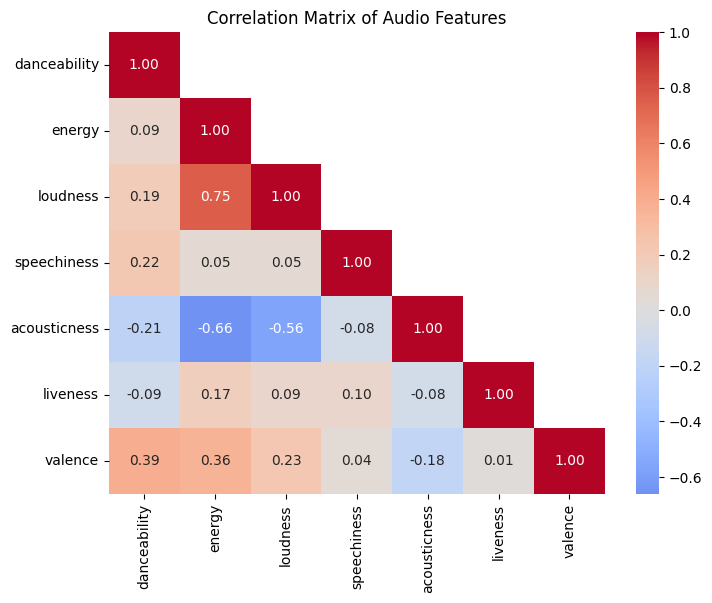

In [19]:
correlation_matrix = audio_features_df[audio_features_list].corr()

# Create a mask to hide the lower triangle (including the diagonal)
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Plotting the correlation matrix as a heatmap, showing only the values in the upper triangle
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0, mask=~mask)
plt.title("Correlation Matrix of Audio Features")
plt.savefig(f"../../resources/audio_feature_plots/correlation.png", format="png", dpi=50)
plt.show()

## Audio Feature Trend Over the Years
Here's how the audio_features change over time

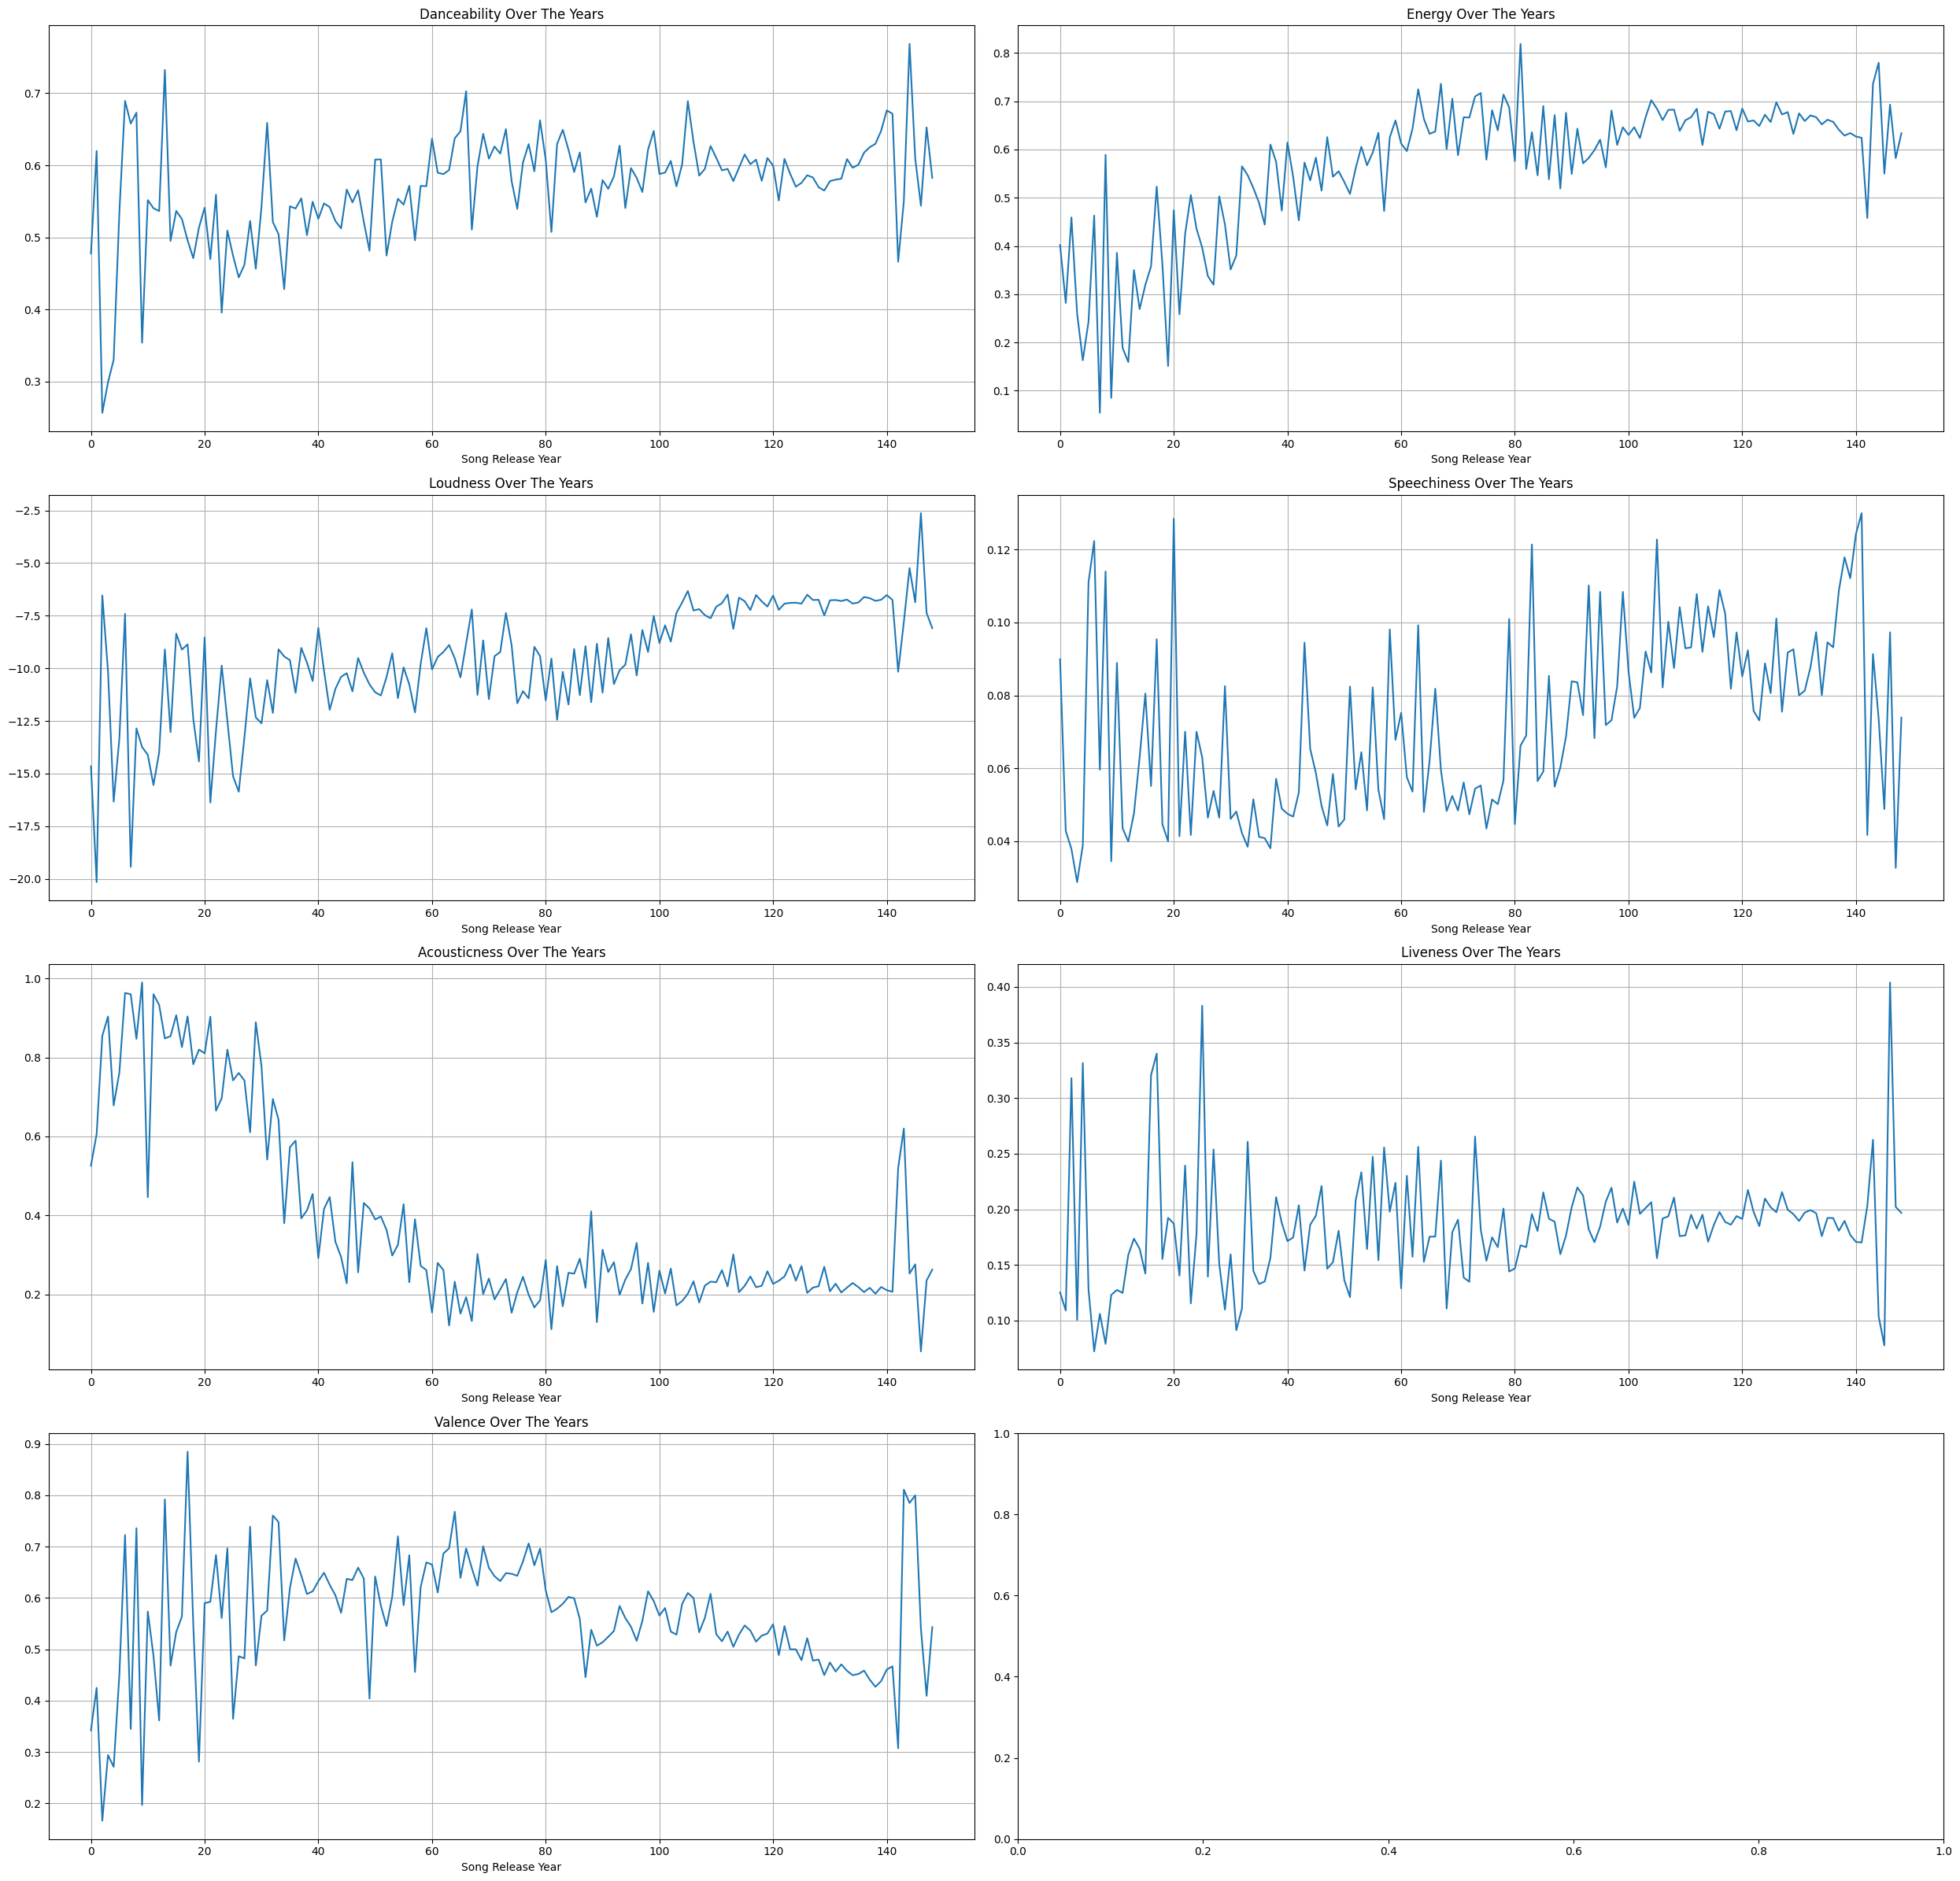

In [25]:
trend_analysis_df = original_merged_df.copy()

trend_analysis_df = trend_analysis_df.dropna(subset=['release_date'])
selected_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'release_date']
trend_analysis_df = trend_analysis_df[selected_columns]

trend_analysis_df['release_date'] = pd.to_datetime(trend_analysis_df['release_date'], errors='coerce')

trend_analysis_df['release_year'] = trend_analysis_df['release_date'].dt.to_period('Q').astype(str)
trend_analysis_df['release_year'] = trend_analysis_df['release_year'].apply(lambda x: x.replace('Q1', 'H1').replace('Q2', 'H1').replace('Q3', 'H2').replace('Q4', 'H2'))

trend_analysis_df = trend_analysis_df.groupby('release_year').mean().reset_index()

subplots_per_row = 2
num_rows = len(audio_features_list) // subplots_per_row + (len(audio_features_list) % subplots_per_row > 0)
fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(25, 6 * num_rows))
axes = axes.flatten()

for i, audio_feature in enumerate(audio_features_list):

    ax = axes[i]
    ax.plot(trend_analysis_df.index, trend_analysis_df[audio_feature], label=audio_feature)
    
    ax.set_xlabel('Song Release Year')
    ax.set_title(f'{audio_feature.capitalize()} Over The Years')
    ax.grid(True)

#     # x_ticks: how often a label is drawn, x_labels: what the label is
#     x_ticks = trend_analysis_df.index[::120]
#     x_labels = [date.split("-")[0] for date in trend_analysis_df['release_year_month'][::120]]
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels(x_labels, rotation=45)

plt.tight_layout()
plt.show()